# **NumPy Implementation of Fully Connected Neural Network**

*Ming Ming Zhang*

Implement an $L$-layer ReLU network for any integer $L>0$ with $L_1$ or $L_2$-regularized softmax loss and stochastic gradient descent in Numpy.

The implementation is based on *Derivatives in fully connected neural networks* by Ming Ming Zhang. In addition, numeric stability and gradients checking are added.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

**1. Implementation**

In [0]:
# Helper functions for fully connected layers.

def linear_forward(H_prev, W, b):
  """
  Computes the linear forward.

  Inputs:
  -H_prev: numpy of shape (D_in,N) where D_in is the dimension of H_prev and N is the number of examples
  -W: numpy of shape (D_out,D_in) weight parameter, where D_out is the dimension of next layer
  -b: numpy of shape (D_out,1) bias parameter

  Outputs:
  -Z: numpy of shape (D_out,N) linear forward output
  -cache: tuple of (H_prev, W, b)
  """

  Z = np.dot(W, H_prev) + b
  cache = (H_prev, W, b)

  return Z, cache


def relu_forward(Z):
  """
  Computes the ReLU activation forward.

  Input:
  -Z: numpy from linear forward

  Outputs:
  -H: numpy of shape (D_out,N)
  -cache: Z 
  """

  H = np.maximum(0, Z)
  cache = Z

  return H, cache


def relu_backward(dH, cache):
  """
  Computes the ReLU activation backward.

  Inputs:
  -dH: numpy of shape (D_out,N) gradient of loss wrt H
  -cache: Z from relu_forward

  Ouput:
  -dZ_prev: numpy of shape (D_in,N) gradient of loss wrt Z_prev
  """

  Z_prev = cache

  dReLU = np.zeros_like(Z_prev)
  dReLU[Z_prev>0] = 1
  dZ_prev = dH * dReLU

  return dZ_prev


def linear_backward(dZ, cache):
  """
  Computes the linear backward.

  Inputs:
  -dZ: numpy of shape (D_out,N) gradient of loss wrt Z
  -cache: tuple (H_prev, W, b) from linear_forward

  Outputs:
  -dH_prev: numpy of shape (D_in,N) gradient of loss wrt H_prev
  -dW: numpy of shape (D_out,D_in) gradient of loss wrt W
  -db: numpy of shape (D_out,1) gradient of loss wrt b
  """

  H_prev, W, b = cache

  dH_prev = np.dot(W.T, dZ)
  dW = np.dot(dZ, H_prev.T)
  db = np.sum(dZ, axis=1, keepdims=True)

  return dH_prev, dW, db


def softmax_loss(Z_L, y):
  """
  Computes the softmax loss and its gradient.

  Inputs:
  -Z_L: numpy of shape (C,N) from linear_forward where C is number of classes
  -y: numpy of shape (N,) true labels

  Outputs:
  -loss: scalar data loss
  -dZ_L: numpy of shape (C,N) gradient of loss wrt Z_L
  """

  N = Z_L.shape[1]
  C = Z_L.shape[0] 

  # Numeric stability, by subtracting a value k max over scores Z_L
  k = np.max(Z_L, axis=0).reshape((1,-1)) # (1, N)
  Z_L -= k # (C, N)
  H = np.exp(Z_L) / np.sum(np.exp(Z_L), axis=0, keepdims=True)
  L = -np.log(H[y, range(N)]) # (C,N)
  loss = np.sum(L) / N # a scalar

  Y = np.zeros((C,N)) # one-hot vector of the label y
  Y[y, range(N)] = 1
  dZ_L = (H - Y) / N

  return loss, dZ_L

In [0]:
class FCNet_NP(object):
  """
  Build a fully connected L-layer neural network with ReLU activation function,
  and L1/L2 regularized softmax loss function, i.e.,
  {linear - relu} * (L-1) - linear - softmax.
  """


  def __init__(self, input_dim, hidden_dims, num_classes, reg=0.0, reg_method='L2', weight_scale=None, dtype=np.float32):
    """
    Initialize a fully connected neural network.

    Inputs:
    -input_dim: integer>0 the size of input
    -hidden_dims: list of integers>0 the size of l-th hidden layer for each l in {1,...,L-1}
    -num_classes: integer>1 the number of classes to classify
    -reg: scalar L1 or L2 regularization strength
    -reg_method: string 'L1' or 'L2' regularization
    -weight_scale: scalar the standard deviation for random initialization of the weights
    -dtype: numpy datatype
    """

    self.reg = reg
    self.reg_method = reg_method
    self.dtype = dtype
    self.num_layers = 1 + len(hidden_dims) # number L of layers in the network
    self.params = {}

    layer_dims = [input_dim] + hidden_dims + [num_classes] # dimension of all l-layers for l in {0,1,...,L}
    
    for l in range(1, len(layer_dims)): # note that len(layer_dims)-1 is L the number of layers
      if weight_scale is None:
        self.params['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * np.sqrt(2.0/layer_dims[l-1])
      if weight_scale is not None:
        self.params['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * weight_scale
      self.params['b'+str(l)] = np.zeros((layer_dims[l],1))

    for k, v in self.params.items(): # cast parameters to the specified datatype
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Computes the training-time loss and gradients, and test-time classification scores.

    Inputs:
    -X: numpy of shape (D,N) data matrix, where D is the dimension and N is the number of examples
    -y: numpy of shape (N,) true labels

    Outputs:
    -Z_L: numpy of shape (num_classes,N) scores (linear output of last layer) if y=None 
    -loss: scalar loss if y!=None
    -grads: dictionary of gradients if y!=None
    """

    X = X.astype(self.dtype)
    L = self.num_layers
    caches = []
    H = X

    for l in range(1,L):
      H_prev = H
      Z, cache_linear = linear_forward(H_prev, self.params['W'+str(l)], self.params['b'+str(l)])
      H, cache_relu = relu_forward(Z)
      cache = (cache_linear, cache_relu)
      caches.append(cache)
    
    Z_L, cache = linear_forward(H, self.params['W'+str(L)], self.params['b'+str(L)])
    caches.append(cache)

    if y is None:
      return Z_L

    loss, dZ_L = softmax_loss(Z_L, y)

    R = 0.0 # initialize regularization loss
    for l in range(1,L+1):
      if self.reg_method == 'L1': # L1-regularization loss
        R += self.reg * np.sum(np.absolute(self.params['W'+str(l)]))
      elif self.reg_method == 'L2': # L2-regularization loss
        R += 0.5 * self.reg * np.sum(np.square(self.params['W'+str(l)]))
    if self.reg_method == 'L1':
      loss += R 
    elif self.reg_method == 'L2':
      loss += R

    grads = {}

    dH_prev, dWL, dbL = linear_backward(dZ_L, cache)
    dH_prev_temp = dH_prev
    grads['W'+str(L)] = dWL
    grads['b'+str(L)] = dbL
    for l in reversed(range(L-1)):
      dH = dH_prev_temp
      cache_linear, cache_relu = caches[l]
      dZ = relu_backward(dH, cache_relu)
      dH_prev_temp, dW, db = linear_backward(dZ, cache_linear)
      grads['W'+str(l+1)] = dW
      grads['b'+str(l+1)] = db

    for l in range(1,L+1):
      if self.reg_method == 'L1':
        grads['W'+str(l)] += self.reg * np.sign(self.params['W'+str(l)]) 
      elif self.reg_method == 'L2':
        grads['W'+str(l)] += self.reg * self.params['W'+str(l)]

    return loss, grads

In [0]:
class Solver(object):
  """
  Build a solver to train a model object which performs stochastic gradient descent update.
  """


  def __init__(self, model, data, **kwargs):
    """
    Construct a solver.

    Inputs:
    -model: model object containing API model.params and model.loss described as above.
    -data: dictionary of training and validation data, i.e., X_train, X_val, y_train, y_val

    Optional arguments:
    -lr: scalar step size (learning rate) in stochastic gradient descent update
    -lr_decay: scalar for learning rate decay after each epoch
    -batch_size: size of minibatches used to compute loss and gradient during training
    -num_epochs: the number of epochs to run for during training
    -print_every: integer>0 training losses will be printed every print_every iterations
    -verbose: boolean, no output will be printed during training if set to false
    -metric_method: string 'acc' or 'f1'
    """

    self.model = model
    self.X_train = data['X_train']
    self.X_val = data['X_val']
    self.y_train = data['y_train']
    self.y_val = data['y_val']

    self.lr = kwargs.pop('lr', 1e-2)
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch-size', 32)
    self.num_epochs = kwargs.pop('num_epochs', 10)
    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)
    self.metric_method = kwargs.pop('metric_method', 'acc')

    self.__reset()

  def __reset(self):
    """
    Reset some varibles for optimization.
    """

    self.epoch = 0
    self.best_val = 0.0
    self.best_params = {}
    self.loss_history = []
    self.train_history = []
    self.val_history = []


  def __step(self):
    """
    A single step of gradient update used in train() below.
    """

    num_train = self.X_train.shape[1]
    batch_mask = np.random.choice(num_train, self.batch_size)
    X_batch = self.X_train[:, batch_mask]
    y_batch = self.y_train[batch_mask]

    loss, grads = self.model.loss(X_batch, y_batch)
    self.loss_history.append(loss)

    for k, v in self.model.params.items():
      dv = grads[k]
      v += -self.lr * dv 
      self.model.params[k] = v


  def check_prediction(self, X, y):
    """
    Check prediction of the model on the given data.

    Inputs:
    -X: numpy of shape (D,N) data matrix
    -y: numpy of shape (N,) labels
    -metric_method: string 'acc' accuracy or 'f1' F1-score

    Outputs:
    -metric_score: scalar the score correctly classified by the model 
    """

    scores = self.model.loss(X)
    y_hat = np.argmax(scores, axis=0)

    if self.metric_method == 'acc':
      metric_score = np.mean(y_hat == y)
    elif self.metric_method == 'f1':
      tp = np.sum((y_hat == 1) & (y == 1))
      fp = np.sum((y_hat == 1) & (y == 0))
      fn = np.sum((y_hat == 0) & (y == 1))
      prec = tp / (tp+fp+1e-8) 
      rec = tp / (tp+fn+1e-8)
      metric_score = 2*prec*rec / (prec+rec+1e-8)
    
    return metric_score


  def train(self):
    """
    Train the model using stochastic gradient descent.
    """

    num_train = self.X_train.shape[1]
    iterations_per_epoch = max(num_train // self.batch_size, 1)
    num_iterations = self.num_epochs * iterations_per_epoch

    for t in range(num_iterations):
      self.__step()

      if self.verbose and t % self.print_every == 0:
        print('(Iteration %d / %d) loss: %f' % (t + 1, num_iterations, self.loss_history[-1]))

      epoch_end = ((t + 1) % iterations_per_epoch == 0)
      if epoch_end:
        self.epoch += 1
        self.lr *= self.lr_decay

      first_it = (t == 0)
      last_it = (t == num_iterations - 1)
      if first_it or last_it or epoch_end:
        train_score = self.check_prediction(self.X_train, self.y_train)
        val_score = self.check_prediction(self.X_val, self.y_val)
        self.train_history.append(train_score)
        self.val_history.append(val_score)

        if self.verbose:
          print('(Epoch %d / %d) train_score: %f; val_score: %f' % (self.epoch, self.num_epochs, train_score, val_score))

        if val_score > self.best_val:
          self.best_val = val_score
          self.best_params = {}
          for k, v in self.model.params.items():
            self.best_params[k] = v.copy()

    self.model.params = self.best_params

**2. Sanity Checks**

In [0]:
# Gradient checking for 2-layer network

def dictionary_to_vector(params):
    """
    Convert parameters dictionary into a vector.
    
    Input:
    -params: dictionary parameters W's and b's

    Output:
    -theta: the vector
    -keys: list of keys of parameters
    """

    keys = []
    count = 0

    for key in ["W1", "b1", "W2", "b2"]:
        v = np.reshape(params[key], (-1,1))
        keys = keys + [key] * v.shape[0]
        
        if count == 0:
            theta = v
        else:
            theta = np.concatenate((theta, v), axis=0)
        count = count + 1

    return theta, keys


def gradients_to_vector(grads):
    """
    Convert gradients dictionary into a vector.

    Input:
    -grads: gradients dictionary

    Ouput:
    -theta: the vector
    """

    count = 0

    for key in ["W1", "b1", "W2", "b2"]:
        v = np.reshape(grads[key], (-1,1))
        
        if count == 0:
            theta = v
        else:
            theta = np.concatenate((theta, v), axis=0)
        count = count + 1

    return theta


def vector_to_dictionary(theta):
    """
    Convert a vector to parameters dictionary.

    Input:
    -theta: the vector

    Ouput:
    -params: parameters dictionary
    """

    params = {}

    params["W1"] = theta[:12].reshape((3,4))
    params["b1"] = theta[12:15].reshape((3,1))
    params["W2"] = theta[15:21].reshape((2,3))
    params["b2"] = theta[21:24].reshape((2,1))

    return params


def gradient_check(model, X, y, epsilon=1e-7):
    """
    Checks if the gradients of FCNet_NP computes correctly.
    
    Inputs:
    -model: FCNet_NP
    -X: random data matrix generated in gradient_check_data()
    -y: true labels generated in gradient_check_data()
    -epsilon: tiny shift in numerical gradient
    
    Output:
    -difference: difference between the numerical and analytical gradient
    """
  
    params = model.params
    _, grads = model.loss(X, y)
    v_params, _ = dictionary_to_vector(params)
    v_grads = gradients_to_vector(grads)
    n = v_params.shape[0]
    L_plus = np.zeros((n, 1))
    L_minus = np.zeros((n, 1))
    gradapprox = np.zeros((n, 1))
    
    for i in range(n):
        thetaplus = np.copy(v_params)  
        thetaplus[i][0] = thetaplus[i] + epsilon
        paramsplus = vector_to_dictionary(thetaplus)
        model.params = paramsplus
        L_plus[i], _ = model.loss(X, y,)
      
        thetaminus = np.copy(v_params)  
        thetaminus[i][0] = thetaminus[i] - epsilon
        paramsminus = vector_to_dictionary(thetaminus)
        model.params = paramsminus
        L_minus[i], _ = model.loss(X, y)   
       
        gradapprox[i] = (L_plus[i] - L_minus[i]) / (2*epsilon)
    
    numerator = np.linalg.norm(v_grads - gradapprox) 
    denominator = np.linalg.norm(v_grads) + np.linalg.norm(gradapprox) 
    difference =  numerator / denominator 

    return difference

In [0]:
# Gradient checking

N, D, H1, C = 3, 4, 3, 2
X = np.random.randn(D,N)
y = np.array([1,1,0])

reg_methods = ['L1', 'L2']
for i in range(2):
   model = FCNet_NP(input_dim=D, hidden_dims=[H1], num_classes=C, reg_method=reg_methods[i], dtype=np.float64)
   for reg in [0.0, 0.8]:
     model.reg = reg
     error = gradient_check(model, X, y)
     print('%s-regularization %.1f difference %.2e' % (reg_methods[i], reg, error))

L1-regularization 0.0 difference 2.42e-09
L1-regularization 0.8 difference 5.38e-09
L2-regularization 0.0 difference 2.47e-09
L2-regularization 0.8 difference 1.16e-09


In [0]:
# Loss checking

N, D, H1, C = 3, 5, 50, 10
X = np.random.randn(D,N)
y = np.random.randint(C, size=(N,))

correct_loss = -np.log(1/C)
reg_methods = ['L1', 'L2']
for i in range(2):
   model = FCNet_NP(input_dim=D, hidden_dims=[H1], num_classes=C, reg_method=reg_methods[i], dtype=np.float64, weight_scale=1e-2)
   for reg in [0.0, 1e1]:
     model.reg = reg
     loss, _ = model.loss(X, y)
     print('%s-regularization %.1f initial loss %.2f, expected loss %.2f' % (reg_methods[i], reg, loss, correct_loss))

L1-regularization 0.0 initial loss 2.30, expected loss 2.30
L1-regularization 10.0 initial loss 58.86, expected loss 2.30
L2-regularization 0.0 initial loss 2.30, expected loss 2.30
L2-regularization 10.0 initial loss 2.66, expected loss 2.30


(Iteration 1 / 10) loss: 1.728099
(Epoch 1 / 10) train_score: 0.533333; val_score: 0.200000
(Epoch 2 / 10) train_score: 0.733333; val_score: 0.000000
(Epoch 3 / 10) train_score: 0.933333; val_score: 0.000000
(Epoch 4 / 10) train_score: 0.933333; val_score: 0.000000
(Epoch 5 / 10) train_score: 1.000000; val_score: 0.000000
(Epoch 6 / 10) train_score: 1.000000; val_score: 0.000000
(Epoch 7 / 10) train_score: 1.000000; val_score: 0.000000
(Epoch 8 / 10) train_score: 1.000000; val_score: 0.000000
(Epoch 9 / 10) train_score: 1.000000; val_score: 0.000000
(Epoch 10 / 10) train_score: 1.000000; val_score: 0.000000


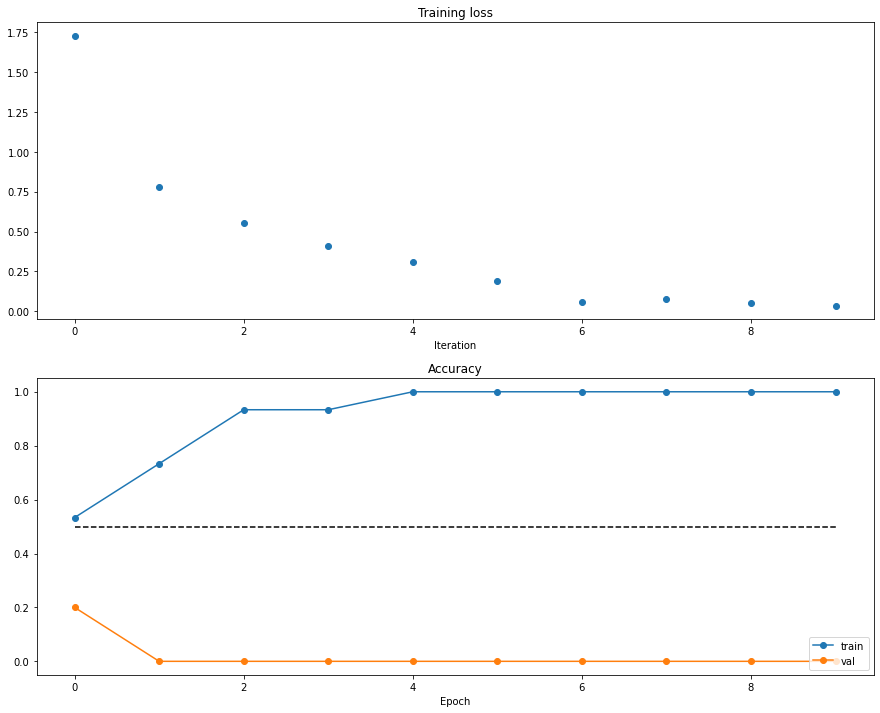

In [0]:
# Overfiting small random data

np.random.seed(123)

N, D, H1, C = 20, 50, 10, 4
X = np.random.randn(D,N)
y = np.random.randint(C, size=(N,))

num_train = 15
num_val = 5
mask = list(range(num_train))
X_train = X[:, mask]
y_train = y[mask]
mask = list(range(num_train, num_train+num_val))
X_val = X[:, mask]
y_val = y[mask]

data = {}
data['X_train'] = X_train
data['X_val'] = X_val
data['y_train'] = y_train
data['y_val'] = y_val

lr = 1
metric_method = 'acc'

model = FCNet_NP(input_dim=D, hidden_dims=[H1], num_classes=C)
solver = Solver(model, data, print_every=10, num_epochs=10, lr=lr, metric_method=metric_method)
solver.train()

# Visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_history, '-o', label='train')
plt.plot(solver.val_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()